# <font color='Goldenrod'>*Yellow*</font><font color=#303030> is the new </font> *black*

## <font color=#303030> Abstract</font>
The creation and propagation of false information has existed since the dawn of time.
Behind these misleading elements are often hidden political or financial intentions, in order to gain credit or make competitors lose it.
With the advent of the Internet and the ever faster and more direct flow of information, it is becoming easier every day to deceive your fellow citizens and to be fooled.
The term *fake news* took on a new dimension during the 2016 American presidential election, when Donald Trump used it extensively to describe the media coverage about himself. In this instantaneous era, it becomes crucial to be able to be critical of the information received. With this work, we want to highlight the risks related to the propagation of false information by using the fakes news themselves, from the Liar database. The power that these fake new vehicles hold is mostly in the use and resonance we make of them. Our credulity becomes credibility, it's up to us to turn the equation the other way around!

------

## <font color=#303030> The data story can be found in the following [link](https://nicolasfontbonne.github.io)</font>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import urllib
from urllib.request import Request, urlopen
import json
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup
from PIL import Image
import plotly
plotly.tools.set_credentials_file(username='JCrobe', api_key='vZ65FhHdcxZEuQik1HBM')
import plotly.plotly as py
import plotly.graph_objs as go
import datetime
from scipy import spatial
import itertools
plt.style.use('ggplot')

------

# A) Introduction
## <font color=#303030> Data Loading and Cleaning</font>

The first thing to do when studying the proportion of veracity and extent of information is to obtain the data. Here, the data comes from the [LIAR](https://arxiv.org/pdf/1705.00648.pdf) dataset and is downloaded from the following [address](https://www.cs.ucsb.edu/~william/data/liar_dataset.zip). Since these data are initially used to detect probable false news, they are divided into two sets: one for training and one for testing. For a first exploratory analysis of these data, we will only use the training set which gathers the majority of the data. All the figures given below will therefore be given through the filter of the sampling assumed to be random between the two sets, in addition to the probable bias of entry into the database mentioned above. 

In [4]:
datapath = 'data/liar_dataset/'

The files are simple *tsv* which is similar to *csv* with tabs instead of comma. All the columns names are known from the `README` files that accompany the data.

* **Column 1**: the ID of the statement ([ID].json).
* **Column 2**: the label.
* **Column 3**: the statement.
* **Column 4**: the subject(s).
* **Column 5**: the speaker.
* **Column 6**: the speaker's job title.
* **Column 7**: the state info.
* **Column 8**: the party affiliation.
* **Column 9-13**: the total credit history count, including the current statement.
    * **9**: barely true counts.
    * **10**: false counts.
    * **11**: half true counts.
    * **12**: mostly true counts.
    * **13**: pants on fire counts.
* **Column 14**: the context (venue / location of the speech or statement).

In [5]:
columns = ['ID', 
           'Label', 
           'Statement', 
           'Subject', 
           'Speaker', 
           'Job title', 
           'Home State', 
           'Party Affiliations', 
           'Barely True Counts', 
           'False Counts', 
           'Half True Counts', 
           'Mostly True Counts', 
           'Pants on Fire Counts', 
           'Context']
liar_train = pd.read_csv(datapath + 'train.tsv',delimiter='\t',encoding='utf-8', names = columns)
liar_test = pd.read_csv(datapath + 'test.tsv',delimiter='\t',encoding='utf-8', names = columns)
liar_valid = pd.read_csv(datapath + 'valid.tsv',delimiter='\t',encoding='utf-8', names = columns)

liar_df = pd.concat([liar_train, liar_test, liar_valid])

liar_df.head(2)

ID      Label                                          Statement  \
0   2635.json      false  Says the Annies List political group supports ...   
1  10540.json  half-true  When did the decline of coal start? It started...   

                              Subject         Speaker             Job title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   

  Home State Party Affiliations  Barely True Counts  False Counts  \
0      Texas         republican                 0.0           1.0   
1   Virginia           democrat                 0.0           0.0   

   Half True Counts  Mostly True Counts  Pants on Fire Counts          Context  
0               0.0                 0.0                   0.0         a mailer  
1               1.0                 1.0                   0.0  a floor speech.

In [6]:
liar_df.shape

(12791, 14)

------

Since we wish to extend our analysis to other fields that are not accessible with the initial data, we will use the politifact [API](https://www.politifact.com//api/v/2/statement/1123/?format=json) in due course to enrich our data. For example, from a temporal analysis perspective, we can imagine integrating the date of the classified intervention into our data table. The same applies to obtaining the entire quotation in question.

This function allows to extract additionnal information from the politifact website by downloading the json source file and returning the json structure parsed.

In [7]:
def get_additional_info(ID):
    idx =  re.search("[0-9]*", ID)
    req = Request('http://www.politifact.com//api/v/2/statement/'+idx.group()+'/?format=json', headers={'User-Agent': 'Mozilla/5.0'})
    response = urllib.request.urlopen(req, timeout=10).read().decode('utf-8')
    a = json.loads(response)
    return a

The politifact API gives us access to the following fields for each statement:

In [8]:
for key in get_additional_info("1123.json").keys():
    print(key)

art
author
canonical_url
edition
editor
facebook_headline
id
in_future
is_pundit
make_public
preview
researcher
resource_uri
ruling
ruling_comments
ruling_comments_date
ruling_date
ruling_headline
ruling_headline_slug
ruling_link_text
ruling_state
source_documents
sources
speaker
statement
statement_context
statement_date
statement_type
subject
target
twitter_headline


For example, we can identify the *content* of the statement and its *twitter headline* for statement with id = 11972

In [9]:
print(BeautifulSoup(get_additional_info("11972.json")['statement'], 'html.parser').prettify())

<p>
 "Building a wall" on the U.S.-Mexico border "will take literally years."
</p>



In [10]:
print(get_additional_info("11972.json")['twitter_headline'])

Extended ladder business expect to explode


In general, we can enrich the original dataset with interesting columns from the API, using the following method:

In [11]:
def enrich(df, column_name):
    '''
    Return an enriched version of the original dataset
    Input:
        df:           dataframe of dataset
        column_name:  column from API
    Output:
        dataframe joined with the API field
    '''
    df[column_name] = pd.Series(np.zeros(len(df)), index=df.index)
    for i in range(0,len(df)):
        df.loc[i,column_name] = get_additional_info(df.loc[i,'ID'])[column_name]

We have executed this request for all statement and saved the result in the date.csv file. The code to get this file is in the root and names `enrich.py`

In [12]:
date = pd.read_csv('data/date.csv', encoding='utf-8', names = ['ID', 'statement_date'], parse_dates = [1])

We can then merge the data to all the stat

In [13]:
liar_df = liar_df.merge(date, on = 'ID')

In [14]:
liar_df.sort_values(by=['statement_date'], inplace = True)
liar_df = liar_df.reset_index(drop = True)
liar_df.head(1)

ID  Label                                          Statement  \
0  1978.json  false  On whether a U.S. Supreme Court nominee should...   

                          Subject      Speaker               Job title  \
0  kagan-nomination,supreme-court  elena-kagan  U.S. solicitor general   

  Home State Party Affiliations  Barely True Counts  False Counts  \
0   New York           democrat                 0.0           0.0   

   Half True Counts  Mostly True Counts  Pants on Fire Counts  \
0               1.0                 0.0                   0.0   

                Context statement_date  
0  a law review article     1995-04-01

---
We notice that fields like *Subject* contain lists of mutiple values, for exemple :

In [15]:
liar_df[["ID","Subject"]].head(1)

ID                         Subject
0  1978.json  kagan-nomination,supreme-court

In order to compute statistics for individual subjects, we design a generic way to split these lists among multiple rows.

In [16]:
def split_col_lists(df,column,delim=","):
    '''
    Split a column containing list of elements, into multiple rows
    Input:
        df:     input dataset
        column: column containing multiple values per row i.e 'Subject'
    Output:
        Lists of elements for the specified column are split into multiple ones,
        keeping the rest of the row identical.
    '''
    split_df = df[column].str.split(delim).apply(pd.Series,1).stack()
    split_df.index = split_df.index.droplevel(-1)
    return df.drop([column],axis=1).join(split_df.to_frame()).rename(columns = {0:column})

In [17]:
split_liar_df = split_col_lists(liar_df,'Subject')
split_liar_df[["ID","Subject"]].head()

ID           Subject
0  1978.json  kagan-nomination
0  1978.json     supreme-court
1  2839.json           economy
2  3222.json       city-budget
3  5924.json             taxes

## <font color=#303030> The Politifact datas</font>
To improve our study, we downloaded a very large amount of additional data through the Politifact API. We collected all the data from the site from 2007 to 2018 with their truth value, the speaker, the political party and the date.

All these data were downloaded using the file `downloadPolitifact.py`.

In [18]:
politifact_df = pd.read_csv('politifact.csv',delimiter=',',encoding='utf-8', parse_dates = [0])

In [19]:
politifact_df['Date'] = politifact_df['Date'].dt.to_period('M')
politifact_df = politifact_df[["Date","Label","Speaker", "Political Party", "Subject"]]
politifact_df.head()

Date        Label            Speaker Political Party  \
0 2018-12         True          Roy Blunt      Republican   
1 2018-12    Half True  Christine Lagarde            None   
2 2018-12         True       Mike  Romano        Democrat   
3 2018-12  Mostly True           Bloggers            None   
4 2018-11    Half True     Terry Van Duyn        Democrat   

                         Subject  
0        Federal Budget;Military  
1             Economy;Jobs;Women  
2                 Income;Poverty  
3  Homeland Security;Immigration  
4                      Elections

In [20]:
politifact_df.shape

(15520, 5)

In this dataset (which is larger than the previous one) we get all the data from the beggining of the Donald Trump presidency, which is intersting for our observation.

---
## <font color=#303030> Some simple statistics</font>

In this section, we will quickly explore the datasets in order to understand their size and caracteristics.

* For the liar database :

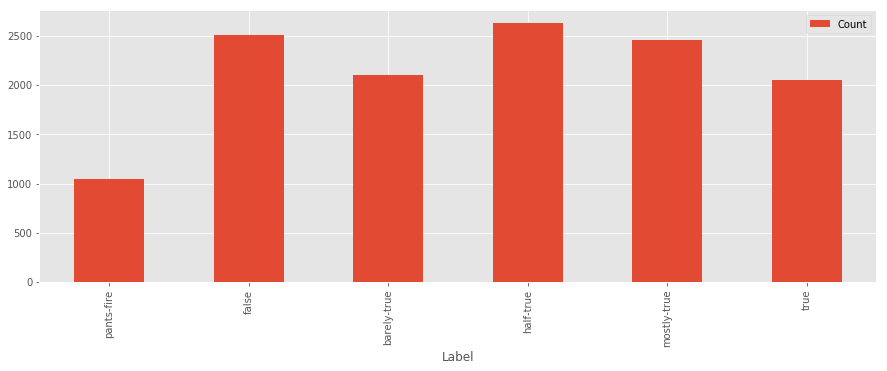

In [21]:
label_distribution = liar_df.groupby("Label").count()
label_distribution = label_distribution[["ID"]]
label_distribution.columns = ["Count"]
label_distribution = label_distribution.transpose()[['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']].transpose()
ax = label_distribution.plot(kind='bar', figsize = (15, 5))
#label_distribution

* and the politifact database :

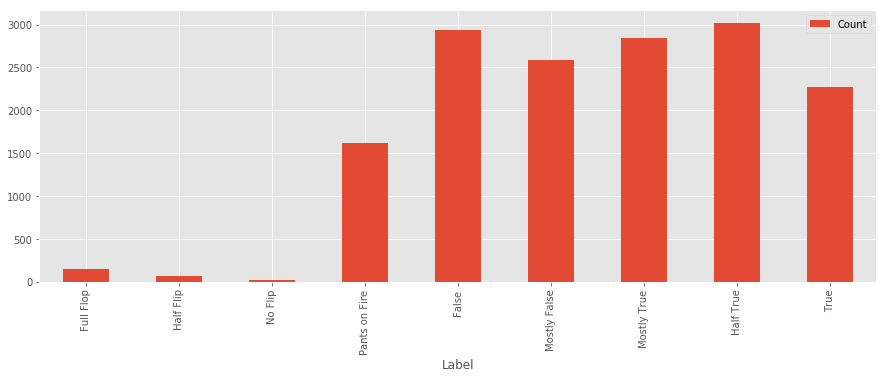

In [22]:
label_distribution = politifact_df.groupby("Label").count()
label_distribution = label_distribution[["Date"]]
label_distribution.columns = ["Count"]
label_distribution = label_distribution.transpose()[['Full Flop', 'Half Flip', 'No Flip', 'Pants on Fire', 'False', 'Mostly False', 'Mostly True', 'Half True','True']].transpose()
ax = label_distribution.plot(kind='bar', figsize = (15, 5))
#label_distribution

The politifact database have three more truth category that all are different type of false statement. They can therefore be considered as `Pants on Fire` or `False` statement.

------

All of the results and interpretation we can have from this dataset depend on its method of data collection. More precisely, the dataset has been constructed from differents sources of media. This selection can be biased. To lower the impact of this bias, the authors have make sure to balance the numbers of article extrated between the two american political parties. But this balance can or cannot represent the reality. It can be interesting to check if their sampling can be considered as representative or not.

---
# B) The fake news menace 
## <font color=#303030> Some time analysis</font>
In this part we will study some evolution of the data over time. Every statement have a date associated. The day information has been croped to regroup every statement of the same month.

It can be intersting to seen what is the time span of our data :

In [23]:
time_span = liar_df.loc[liar_df.shape[0]-1, 'statement_date'] - liar_df.loc[0, 'statement_date']
print(time_span)

7925 days 00:00:00


In [24]:
liar_df['statement_date'] = liar_df['statement_date'].dt.to_period('M')

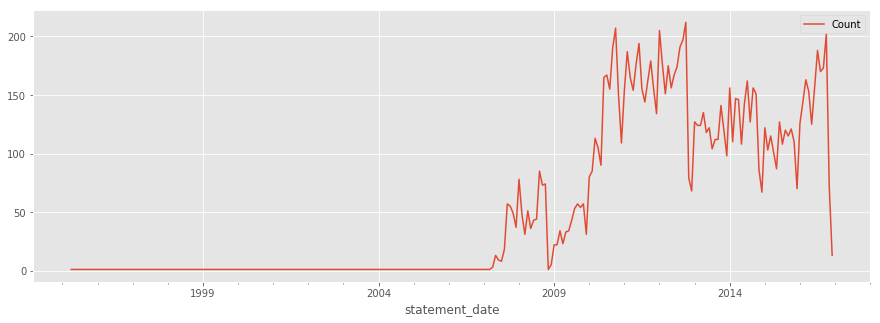

In [25]:
count_time = liar_df.groupby('statement_date').count()[['ID']]
count_time.columns = ['Count']
#count_time = count_time[datetime.datetime(2010, 1, 1):]
count_time.plot(figsize=(15, 5))

The time span is very large due to some outliers. The politifact contributors can choose any article to review which explain the 1995 datapoint.

As the number of point increase since 2009, we will focus more when the number of datapoint is more constant after 2010.

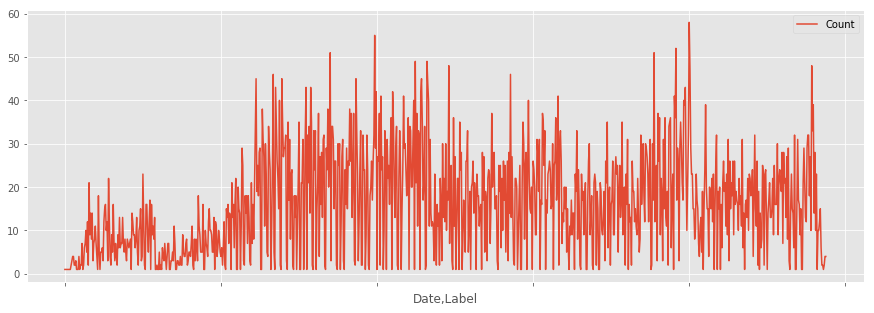

In [26]:
count_time = politifact_df.groupby(['Date','Label']).count()[['Subject']]
count_time.columns = ['Count']
#count_time = count_time[datetime.datetime(2010, 1, 1):]
count_time.plot(figsize=(15, 5))

The same observation can be made on the politifact data. We just have more data and more density.

Then we can compute the evolution of the percentage of false information.

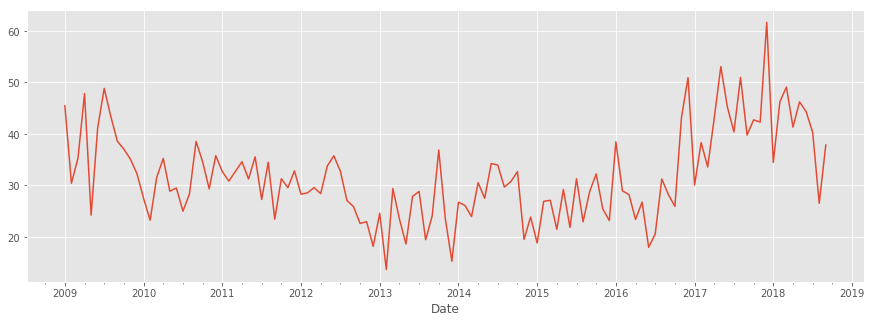

In [27]:
false_db = politifact_df.groupby(['Date','Label']).count()[['Subject']]
false_db = false_db.unstack('Label')
false_db = false_db.fillna(0)
false_db = false_db[[('Subject', 'Full Flop'),
('Subject', 'Half Flip'),
('Subject', 'No Flip'),
('Subject', 'Pants on Fire'),
('Subject', 'False'),
('Subject', 'Mostly False'),
('Subject', 'Mostly True'),
('Subject', 'Half True'),
('Subject', 'True')]]
false_db = false_db[datetime.datetime(2009, 1, 1):datetime.datetime(2018, 9, 1)]
false_db = false_db.div(false_db.sum(axis = 1),axis = 'index')
false_db['False'] = false_db[[
('Subject', 'Full Flop'),
('Subject', 'Half Flip'),
('Subject', 'No Flip'),
('Subject', 'Pants on Fire'),
('Subject', 'False')]].sum(axis = 1)*100
false_db['False'].plot(figsize=(15, 5))

It can be noted that there does not seem to be a clear increase in the number of fake news in the time domain of the database. It is important to note that the number of false information is on average 50% of the total information. The false and the true are in a constant battle. Since 2017, when Donald Trump came into power, falsification of information seems to be gaining ground on its opponent, which can be worrying.

Then we can be interested by looking at this evolution across the two major political parties of USA : the republican and the democrate to see if there is any difference between the two.

In [28]:
republican = politifact_df[politifact_df["Political Party"]=="Republican"]
democrat = politifact_df[politifact_df["Political Party"]=="Democrat"]

In [29]:
rep_false_db = republican.groupby(['Date','Label']).count()[['Subject']]
rep_false_db = rep_false_db.unstack('Label')
rep_false_db = rep_false_db.fillna(0)
rep_false_db = rep_false_db[[('Subject', 'Full Flop'),('Subject', 'Half Flip'),('Subject', 'No Flip'),('Subject', 'Pants on Fire'),('Subject', 'False'),('Subject', 'Mostly False'),('Subject', 'Mostly True'),('Subject', 'Half True'),('Subject', 'True')]]
rep_false_db = rep_false_db[datetime.datetime(2009, 1, 1):datetime.datetime(2018, 9, 1)]
rep_false_db = rep_false_db.div(rep_false_db.sum(axis = 1),axis = 'index')
rep_false_db['Republican'] = rep_false_db[[('Subject', 'Full Flop'),('Subject', 'Half Flip'),('Subject', 'No Flip'),('Subject', 'Pants on Fire'),('Subject', 'False')]].sum(axis = 1)*100


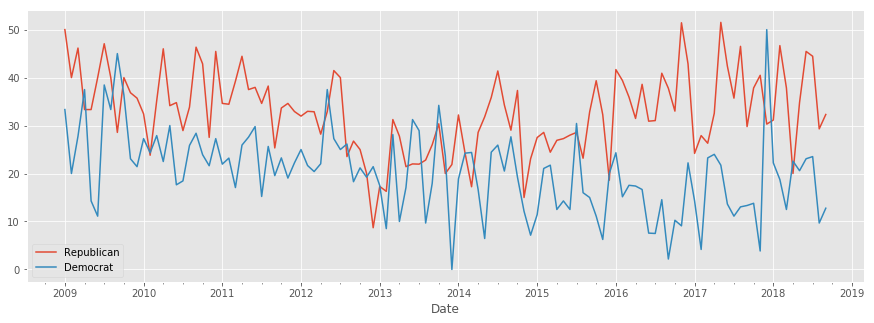

In [30]:
dem_false_db = democrat.groupby(['Date','Label']).count()[['Subject']]
dem_false_db = dem_false_db.unstack('Label')
dem_false_db = dem_false_db.fillna(0)
dem_false_db = dem_false_db[[('Subject', 'Full Flop'),('Subject', 'Half Flip'),('Subject', 'No Flip'),('Subject', 'Pants on Fire'),('Subject', 'False'),('Subject', 'Mostly False'),('Subject', 'Mostly True'),('Subject', 'Half True'),('Subject', 'True')]]
dem_false_db = dem_false_db[datetime.datetime(2009, 1, 1):datetime.datetime(2018, 9, 1)]
dem_false_db = dem_false_db.div(dem_false_db.sum(axis = 1),axis = 'index')
dem_false_db['Democrat'] = dem_false_db[[('Subject', 'Full Flop'),('Subject', 'Half Flip'),('Subject', 'No Flip'),('Subject', 'Pants on Fire'),('Subject', 'False')]].sum(axis = 1)*100

rep_false_db['Republican'].plot(figsize=(15, 5), legend = True)
dem_false_db['Democrat'].plot(figsize=(15, 5), legend = True)

In [31]:
rep_dem = rep_false_db[['Republican']].join(dem_false_db[['Democrat']])
rep_dem = rep_dem.fillna(0)
#rep_dem.to_csv("RepDem.csv")

We can observe that the lie rate of both American parties is generally constant. It must be said that the Republican Party produces much more lies than the Democratic Party. This is espetially true since 2016 and the Donald Trump election.

---
## <font color=#303030>Some interesting distributions</font> 
In this section, we will study the distributions of truth according to some interesting parameters or features.

These two functions get the projection of the truth distribution across the chosen feature, for the two datasets

In [32]:
def get_truth_distribution(data, col_name, count_threshold, normalize = True):
    '''
    Return the distribution of truth outcomes for values of a particular column.
    Input:
        data:           input dataset
        col_name:       column of the dataset
        count_treshold: minimum number of statements for each column value
        normalize:      whether to normalize number of statements per value
    Output:
        For each popular enough value, return its distribution of truthfulness
    '''
    df = data[[col_name, "ID", "Label"]]
    df.columns = [col_name, "Percent", "Label"]
    col_subject = df.groupby([col_name, "Label"]).count()[["Percent"]]
    col_subject = col_subject.unstack('Label')
    col_subject = col_subject.fillna(0)
    col_subject = col_subject[[('Percent', 'pants-fire'),
                               ('Percent', 'false'),
                               ('Percent', 'barely-true'),
                               ('Percent', 'half-true'),
                               ('Percent', 'mostly-true'),
                               ('Percent', 'true')]]
    col_subject = col_subject[col_subject.sum(axis = 1) >= count_threshold]
    if normalize == True:
        col_subject = col_subject.div(col_subject.sum(axis = 1),axis = 'index')
    col_subject = col_subject.sort_values(by=[('Percent', 'pants-fire')], ascending = False)
    return col_subject

In [33]:
def get_truth_distribution_2(data, col_name, count_threshold, normalize = True):
    '''
    Return the distribution of truth outcomes for values of a particular column.
    Input:
        data:           input dataset
        col_name:       column of the dataset
        count_treshold: minimum number of statements for each column value
        normalize:      whether to normalize number of statements per value
    Output:
        For each popular enough value, return its distribution of truthfulness
    '''
    df = data[[col_name, "Date", "Label"]]
    df.columns = [col_name, "Percent", "Label"]
    col_subject = df.groupby([col_name, "Label"]).count()[["Percent"]]
    col_subject = col_subject.unstack('Label')
    col_subject = col_subject.fillna(0)
    col_subject = col_subject[[('Percent', 'Full Flop'),
                                ('Percent', 'Half Flip'),
                                ('Percent', 'No Flip'),
                                ('Percent', 'Pants on Fire'),
                                ('Percent', 'False'),
                                ('Percent', 'Mostly False'),
                                ('Percent', 'Mostly True'),
                                ('Percent', 'Half True'),
                                ('Percent', 'True')]]
  
    col_subject = col_subject[col_subject.sum(axis = 1) >= count_threshold]
    if normalize == True:
        col_subject = col_subject.div(col_subject.sum(axis = 1),axis = 'index')*100
        
    col_subject = col_subject.sort_values(by=[('Percent', 'False')], ascending = False)
    return col_subject

We now want to study which labels are most often reported by subject. To do this, we first check that the labels indicated in the Readme file of the initial database are those found after the import of the database.

In [34]:
liar_df['Label'].unique()

array(['false', 'barely-true', 'mostly-true', 'half-true', 'true',
       'pants-fire'], dtype=object)

This is indeed the case. Since we are examining subjects, we should split rows containing lists of them in individual ones.

In [35]:
print("{} rows expanded to {}".format(len(liar_df),len(split_liar_df)))

12791 rows expanded to 27683


In [36]:
subject_distribution = get_truth_distribution(split_liar_df, "Subject", 700)

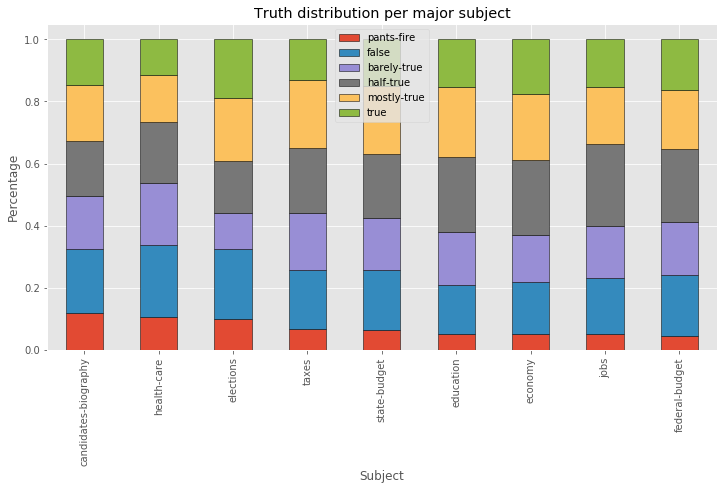

In [37]:
ax = subject_distribution.plot(kind='bar',
                          stacked=True,
                          ec='black',
                          figsize=(12,6)
                         )
plt.title('Truth distribution per major subject')
plt.xlabel('Subject')
plt.ylabel('Percentage')
ax.legend(subject_distribution.columns.get_level_values(1).tolist())

We can see that the health sector is the most affected by the spread of false news here. While keeping in mind the possible biases of the analysis, it is not surprising to find this theme in the foreground. Indeed, all American citizens are concerned by this particular subject and it is no secret that health costs are a major topic of debate in the United States. In order to win public opinion, or to try to discredit its competitors, this seems to be a privileged subject, just like immigration policies.

---
### <font color=#303030>  What are the preferred formats for which topics?</font>

We would now like to study which are the preferred dissemination formats according to the subject of study. The results presented here are only a rough outline of what they will be in the future, as a finer breakdown of topics must be done for interventions that contain several of them.

### <font color=#856514>  What is the preferred context to lie? </font>

In [38]:
context_distribution = get_truth_distribution(liar_df, "Context", 100) 
context_distribution

Percent                                              \
Label             pants-fire     false barely-true half-true mostly-true   
Context                                                                    
a tweet             0.115789  0.200000    0.152632  0.142105    0.247368   
a television ad     0.099379  0.136646    0.254658  0.298137    0.149068   
a news release      0.087379  0.190939    0.200647  0.194175    0.161812   
a radio interview   0.087302  0.222222    0.150794  0.198413    0.166667   
a TV ad             0.063063  0.175676    0.211712  0.243243    0.198198   
a campaign ad       0.060976  0.134146    0.341463  0.250000    0.128049   
an interview        0.048951  0.237762    0.146853  0.206294    0.223776   
a press release     0.046099  0.170213    0.166667  0.209220    0.212766   
a debate            0.043860  0.210526    0.184211  0.210526    0.175439   
a speech            0.030888  0.162162    0.108108  0.243243    0.231660   
a news conference   0.018692  0.224299    0.121495  0.158879    0.214953   

                             
Label                  true  
Context                      
a tweet            0.142105  
a television ad    0.062112  
a news release     0.165049  
a radio interview  0.174603  
a TV ad            0.108108  
a campaign ad      0.085366  
an interview       0.136364  
a press release    0.195035  
a debate           0.175439  
a speech           0.223938  
a news conference  0.261682

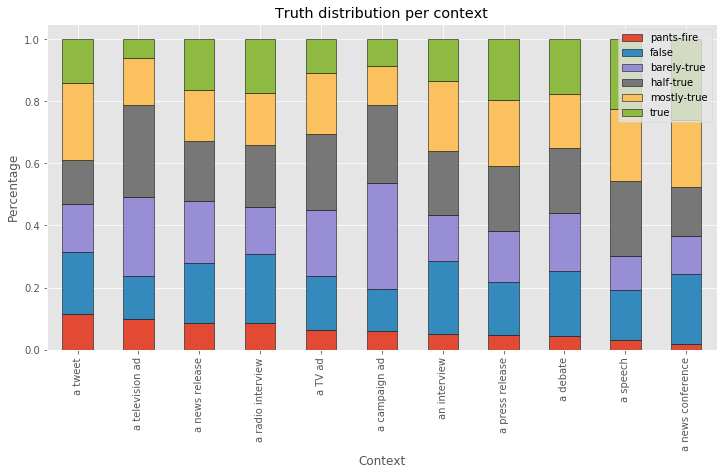

In [39]:
plt.style.use('ggplot')
ax = context_distribution.plot(
    kind='bar',
    stacked=True,
    ec='black',
    figsize=(12,6))
plt.title('Truth distribution per context')
plt.xlabel('Context')
plt.ylabel('Percentage')
ax.legend(context_distribution.columns.get_level_values(1).tolist())

**Note**: *Context* field describes similar types of events in different textual ways. For example there are both `an interview` and `an interview in CNN`. We aim to apply preprocessing, possibly using NLP, to distinguish between them more strictly and update the respective plots.

### <font color=#856514>  Are statements in debates more likely to be lies, compared to other speeches? </font> 

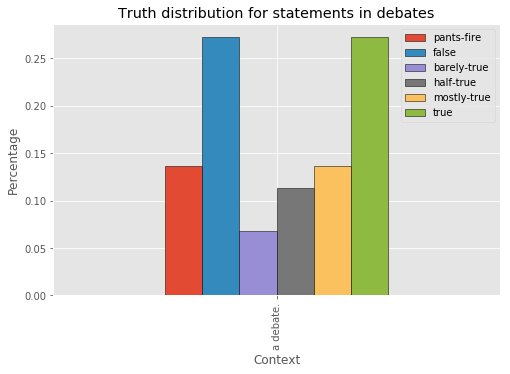

In [40]:
debate = liar_df[liar_df["Context"] == "a debate."]
debate_distribution = get_truth_distribution(debate, "Context", 10)

plt.style.use('ggplot')
groups = debate_distribution.columns.get_level_values(1).tolist()
ind = np.arange(len(groups))  # the x locations for the groups
ax = debate_distribution.plot(width=0.5,
                              kind='bar',
                              ec='black',
                              figsize=(8,5))

plt.title('Truth distribution for statements in debates')
plt.ylabel('Percentage')

ax.legend(groups)

It seems that the debate are quite polarised in truth distribution. Debaters either say completely true or completely false information. The goal in a broadcasted debate is not to find the best solution to a problem but to win the debate by getting most agreement from the audience. Very polarised ideas and false information are intentionaly used because there is no possible immediate fact checking.

### <font color=#856514>  What is the preferred format for each topic? </font> 

### <font color=#856514> Compare distribution of fake news between traditional press, speeches and social media </font> 

The Internet and social networks seem to represent an ideal platform for the spread of false news, as they are anonymous, free and widely available. We would like to compare the distribution of labels assigned to news between traditional media and those from the Internet.

In [41]:
context_distribution = get_truth_distribution(liar_df, "Context", 70, normalize = True) 
context_distribution.head()

Percent                                              \
Label             pants-fire     false barely-true half-true mostly-true   
Context                                                                    
a Facebook post     0.160920  0.206897    0.206897  0.195402    0.149425   
a tweet             0.115789  0.200000    0.152632  0.142105    0.247368   
a television ad     0.099379  0.136646    0.254658  0.298137    0.149068   
a news release      0.087379  0.190939    0.200647  0.194175    0.161812   
a radio interview   0.087302  0.222222    0.150794  0.198413    0.166667   

                             
Label                  true  
Context                      
a Facebook post    0.080460  
a tweet            0.142105  
a television ad    0.062112  
a news release     0.165049  
a radio interview  0.174603

**Traditional press:**

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



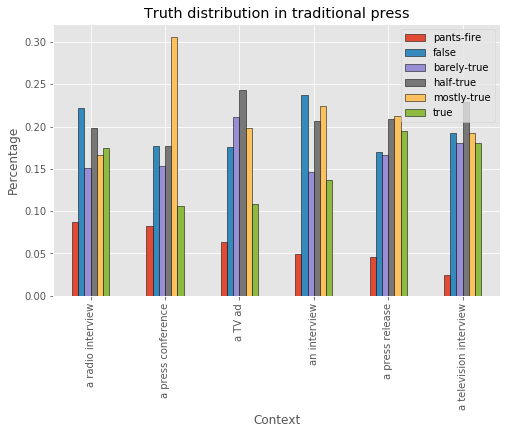

In [42]:
traditional_press_regex = re.compile(r'\b(ABC|TV|CNN|MSNBC|radio|interview|newspaper|press)[s]*\b' ,re.I)
traditional_press_sets = context_distribution[context_distribution.index.str.contains(traditional_press_regex, regex=True) == True]

plt.style.use('ggplot')
groups = traditional_press_sets.columns.get_level_values(1).tolist()
ind = np.arange(len(groups))  # the x locations for the groups
ax = traditional_press_sets.plot(width=0.5,
                              kind='bar',
                              ec='black',
                              figsize=(8,5))

plt.title('Truth distribution in traditional press')
plt.ylabel('Percentage')

ax.legend(groups)

**Social media:**

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



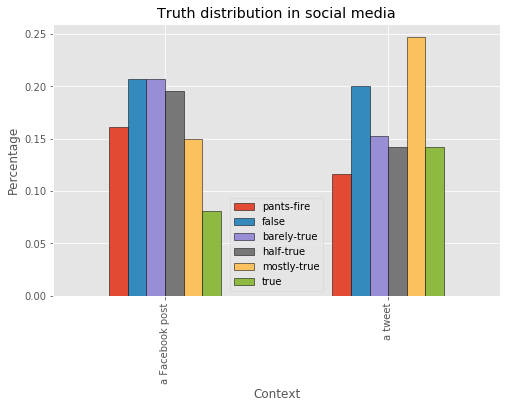

In [43]:
social_media_regex = re.compile(r'\b(Facebook|blog|twitter|my space|newsletter|video|email|tweet|social media|YouTube)[s]*\b' ,re.I)
social_media_sets = context_distribution[context_distribution.index.str.contains(social_media_regex, regex=True) == True]
plt.style.use('ggplot')
groups = social_media_sets.columns.get_level_values(1).tolist()
ind = np.arange(len(groups))  # the x locations for the groups
ax = social_media_sets.plot(width=0.5,
                              kind='bar',
                              ec='black',
                              figsize=(8,5))

plt.title('Truth distribution in social media')
plt.ylabel('Percentage')

ax.legend(groups)

**Speeches:**

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



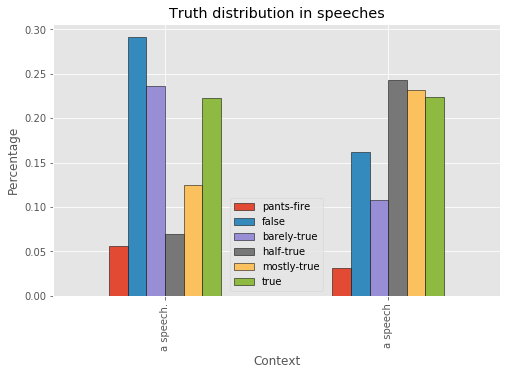

In [44]:
speech_regex = re.compile(r'\b(speech)[s]*\b' ,re.I)
speech_sets = context_distribution[context_distribution.index.str.contains(speech_regex, regex=True) == True]
plt.style.use('ggplot')
groups = speech_sets.columns.get_level_values(1).tolist()
ind = np.arange(len(groups))  # the x locations for the groups
ax = speech_sets.plot(width=0.5,
                              kind='bar',
                              ec='black',
                              figsize=(8,5))

plt.title('Truth distribution in speeches')
plt.ylabel('Percentage')

ax.legend(groups)

---
### <font color=#303030> What are the most prominent professions among the liars?</font> 

From now on, we would like to know which professions are most often reported as liars. Before that, we study the distribution of the categorization of reported news according to the profession of their propagator.

### <font color=#856514> Professions truth distribution ? </font> 

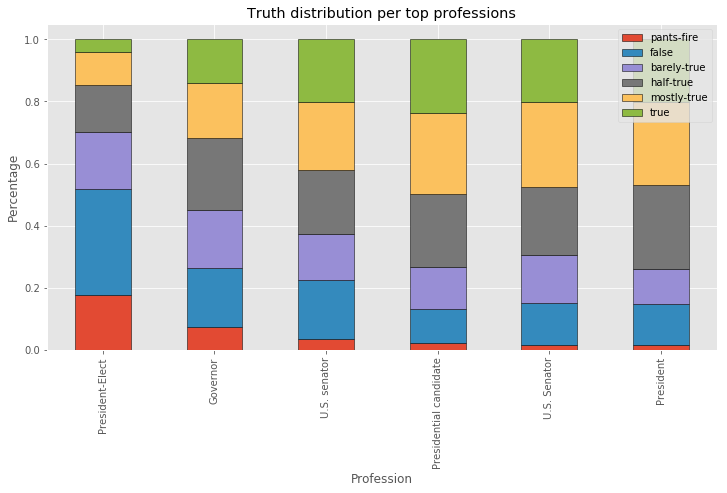

In [45]:
profession_distribution = get_truth_distribution(liar_df, "Job title", 300) 
plt.style.use('ggplot')
ax = profession_distribution.plot(kind='bar',
                                                     stacked=True,
                                                     ec='black',
                                                     figsize=(12,6))
plt.title('Truth distribution per top professions')
plt.xlabel('Profession')
plt.ylabel('Percentage')
ax.legend(profession_distribution.columns.get_level_values(1).tolist())

### <font color=#856514>  What are the most prominent professions in the dataset ? </font> 

In [46]:
jobs = liar_df.groupby("Job title").count()
jobs = jobs.sort_values(by=['ID'], ascending = False)
jobs = jobs[["ID"]]
jobs.head()

ID
Job title           
President        615
U.S. Senator     595
Governor         487
President-Elect  343
U.S. senator     328

### <font color=#856514> And among the liars ? </font> 

For each Statement, we can access the job title of the speaker. That way, we can access the most frequent jobs in the liar groups for this specific dataset.

In [47]:
lie = liar_df[liar_df['Label'] == 'false']
jobs_lie = lie.groupby("Job title").count()
jobs_lie = jobs_lie[["ID"]]

In [48]:
jobs_lie = jobs_lie.sort_values(by=['ID'], ascending = False)
jobs_lie.head()

ID
Job title           
President-Elect  117
Governor          93
President         82
U.S. Senator      80
U.S. senator      62

Because all the jobs don't have the same media coverage, it is more interesting to have the percentage of lie of the job than the raw numbers themselves

In [49]:
jobs_lie = jobs_lie.join(jobs, lsuffix = '_lie', rsuffix = '_total')
jobs_lie["ratio (%)"] =jobs_lie["ID_lie"]/jobs_lie["ID_total"]*100
jobs_lie = jobs_lie.sort_values(by=['ID_total'], ascending = False)
jobs_lie.head(10)

ID_lie  ID_total  ratio (%)
Job title                                              
President                       82       615  13.333333
U.S. Senator                    80       595  13.445378
Governor                        93       487  19.096509
President-Elect                117       343  34.110787
U.S. senator                    62       328  18.902439
Presidential candidate          34       314  10.828025
Former governor                 36       212  16.981132
U.S. Representative             32       210  15.238095
Senator                         44       193  22.797927
Milwaukee County Executive      47       183  25.683060

### <font color=#856514>  What about the politics? </font> 

Since politicians are very often the most visible and most influential and those whose message is most widely conveyed, we can study this area more precisely.

The people that have a political message generaly have a party affiliation.

In [50]:
lie_party = lie[lie['Party Affiliations'] != 'none']
lie_party = lie_party.groupby("Job title").count()
lie_party = lie_party[["ID"]].sort_values(by=['ID'], ascending = False)
lie_party.head(2)

ID
Job title           
President-Elect  117
Governor          93

In [51]:
politics_regex = re.compile(r'\b(mayor|president|council|house|candidate|political|assembly|republican|governor|senator)[s]*\b' ,re.I)
politics_liar_sets = jobs_lie[jobs_lie.index.str.contains(politics_regex, regex=True) == True]
politics_liar_sets.head(2)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



ID_lie  ID_total  ratio (%)
Job title                                
President         82       615  13.333333
U.S. Senator      80       595  13.445378

---
### <font color=#303030> Which political parties tend to lie the most?</font> 

In [52]:
col_subject = get_truth_distribution(liar_df, "Party Affiliations", 2,True)

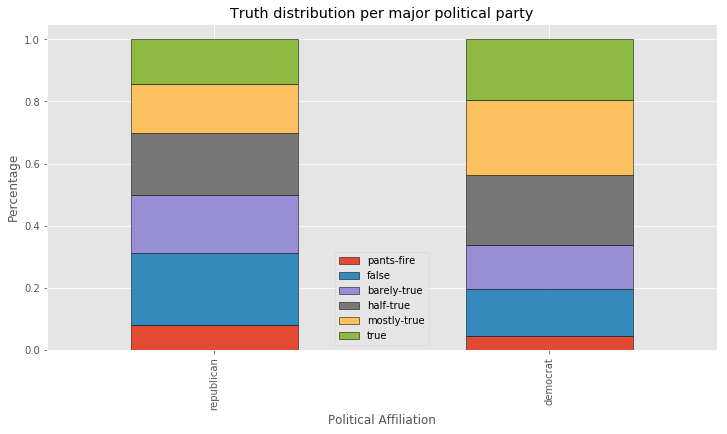

In [53]:
plt.style.use('ggplot')
ax = col_subject.loc[['republican','democrat']].plot(kind='bar',
                                                     stacked=True,
                                                     ec='black',
                                                     figsize=(12,6))
plt.title('Truth distribution per major political party')
plt.xlabel('Political Affiliation')
plt.ylabel('Percentage')
ax.legend(col_subject.columns.get_level_values(1).tolist())

---
# C) The Fake War 

Besides the evolution of fake news over time, we want to compare speakers based on their lying habits. In particular, we look for people that have similar truthfullness patterns. For example, politicians A and B that usually make `True` and `Half True` statements but only a few `Mostly True` and `False` ones. 

In [54]:
def get_top_speakers(subject,n):
    '''
    Get speakers with most graded statements in a particular subject
    Input:
        subject:     subject filter or 'all' to count every statement regardless of subject
        n:           number of top speakers
    Output:
        List of top-n speakers.
    '''
    if subject == 'all':
        speakers = politifact_df['Speaker'].value_counts().index.values
    else:
        speakers =  politifact_df[politifact_df['Subject'].str.contains(subject)]['Speaker'].value_counts().index.values
    speakers = speakers[:n]
    # Chain emails circulate the internet making political claims.
    # We remove them in order to make comparisons between specific politicians
    return np.setdiff1d(speakers,[' Chain email'])

Using this method we can find the 5 most prominent speakers in the dataset:

In [55]:
get_top_speakers('all',5).tolist()

[' Bloggers', 'Barack Obama', 'Donald Trump', 'Hillary Clinton', 'Mitt Romney']

To compare habits in specific subjects, we calculate the 5 most popular ones.

In [56]:
split_df = split_col_lists(politifact_df,'Subject',";")
top_subjects = split_df['Subject'].value_counts().index.values[:5]

In [57]:
top_subjects.tolist()

['Health Care', 'Economy', 'Taxes', 'Education', 'Federal Budget']

Now, it's time to find the distribution of truth labels for every speaker and picked subject.

In [58]:
lies_per_subject = {}
for subject in list(top_subjects) + ['all']:
    # Find top-15 speakers on the subject
    top_speakers = get_top_speakers(subject,15)
    # Only statements from these top speakers
    restricted_df = politifact_df[politifact_df['Speaker'].isin(top_speakers)]
    if subject != 'all':
        # Only statements on the particular subject
        restricted_df = restricted_df[restricted_df['Subject'].str.contains(subject)]
    lie_distrib   = restricted_df.groupby(['Speaker','Label']).size().unstack()
    # Normalize the statistics of each speaker
    norm_lie_distrib = lie_distrib.div(lie_distrib.sum(axis=1),axis=0)
    lies_per_subject[subject] = norm_lie_distrib    

When subjects are not filtered, the percentages of truth-labels per person are the following:

In [59]:
cols = ['True',
        'Mostly True',
        'Half True',
        'Mostly False',
        'False',
        'Pants on Fire',
        'No Flip',
        'Half Flip',
        'Full Flop'
 ]

In [60]:
lies_per_subject['all'][cols]

Label                True  Mostly True  Half True  Mostly False     False  \
Speaker                                                                     
 Bloggers        0.016393     0.025761   0.035129      0.063232  0.201405   
 Facebook posts  0.038462     0.125000   0.134615      0.144231  0.201923   
Barack Obama     0.200321     0.262821   0.259615      0.112179  0.115385   
Bernie Sanders   0.140845     0.359155   0.218310      0.161972  0.119718   
Chris Christie   0.228571     0.171429   0.247619      0.085714  0.171429   
Donald Trump     0.040625     0.114062   0.140625      0.210938  0.332813   
Hillary Clinton  0.250847     0.240678   0.237288      0.142373  0.088136   
John McCain      0.192708     0.203125   0.161458      0.166667  0.203125   
Marco Rubio      0.142857     0.220238   0.232143      0.208333  0.142857   
Mitt Romney      0.137615     0.151376   0.261468      0.160550  0.151376   
Rick Perry       0.149425     0.120690   0.247126      0.183908  0.172414   
Rick Scott       0.088050     0.213836   0.232704      0.188679  0.176101   
Scott Walker     0.134259     0.222222   0.185185      0.157407  0.180556   
Ted Cruz         0.055556     0.173611   0.145833      0.277778  0.263889   

Label            Pants on Fire   No Flip  Half Flip  Full Flop  
Speaker                                                         
 Bloggers             0.658080       NaN        NaN        NaN  
 Facebook posts       0.355769       NaN        NaN        NaN  
Barack Obama          0.017628  0.003205   0.008013   0.020833  
Bernie Sanders             NaN       NaN        NaN        NaN  
Chris Christie        0.066667  0.009524   0.009524   0.009524  
Donald Trump          0.153125       NaN        NaN   0.007812  
Hillary Clinton       0.027119  0.003390        NaN   0.010169  
John McCain           0.041667  0.010417   0.010417   0.010417  
Marco Rubio           0.035714       NaN   0.011905   0.005952  
Mitt Romney           0.091743  0.013761   0.013761   0.018349  
Rick Perry            0.103448       NaN   0.011494   0.011494  
Rick Scott            0.056604  0.006289        NaN   0.037736  
Scott Walker          0.050926  0.004630   0.027778   0.037037  
Ted Cruz              0.069444       NaN        NaN   0.013889

Naturally, to compare two speakers we need to define a similarity metric between their truth vectors calculated above. We choose Euclidean Distance and calculate a distance based similairity.

It is important to note that many rows contain `NaN` values. Instead of filling them with `0`s that would provide false input in our computations, we choose to ignore the respective columns, effectively removing them before the comparison from both sides.

In [61]:
def get_similarity(speaker1,speaker2,subject):
    '''
    Get similarity of two speakers in a particular subject
    Input:
        speaker1,speaker2:     compared speakers
        subject:               specified subject for statements, or 'all'
    Output:
        Similarity value.
    '''
    
    # Get truth vectors for the two speakers
    vector1 = lies_per_subject[subject].loc[speaker1]
    vector2 = lies_per_subject[subject].loc[speaker2]
    # Find columns from either side containing NaN
    mask = ~np.isnan(vector1) & ~np.isnan(vector2)
    # Remove these columns
    vector1 = vector1[mask]
    vector2 = vector2[mask]
    # Return distance-based similarity
    return 1 / (1 +spatial.distance.euclidean(vector1,vector2))

Finally, for every (unique) pair of speakers we compute their similarity value. We repeat the process for every top subject and the case where all subjects are used. We store the results in respective files of `.csv` format. 

In [62]:
for subject in list(top_subjects) + ['all']:
    # Get list of top-speakers in subject (index of array)
    speakers = lies_per_subject[subject].index.values.tolist()
    # For every ordered pair of speakers, compute similarity
    similarities = [
            (p1,
             p2,
             '%.5f' % get_similarity(p1,p2,subject)) for p1,p2 in itertools.combinations(speakers,2)
        ]
    # Save speaker1,speaker2,similarity rows to .csv
    np.savetxt('data/graph/{}.csv'.format(subject),similarities,delimiter=',',fmt='%s')

These records will be used in the front-end application to compute the nodes and edges of a graph showing visually the groups of similar speakers.

---
# D) The Revenge of the Liar 

### Find the most common speakers and subjects in lies

In [63]:
#extract the lies from the inital dataframe
lie = liar_df[(liar_df['Label'] == 'half-true') | (liar_df['Label'] == 'false') | (liar_df['Label'] == 'pants-fire')]
#unstack the possible multiple subjects to make them one by row.
lie = split_col_lists(lie,'Subject')

In [64]:
def sort_array(lie_to_sort,by_colname,n_desired):
    '''
    Groub the data frame by the specify colname, compute the count of the elements and return the n_desired biggest. 
    Input:
        lie_to_sort: input dataset
        by_colname: the column to group by.
    Output:
        lie_sorted: sorted and cropped dataframe
    '''
    lie_to_sort_copy = lie_to_sort
    lie_sorted = lie_to_sort_copy.groupby([by_colname]).count()
    lie_sorted = lie_sorted.sort_values('ID',ascending=False).head(n_desired)
    lie_sorted = pd.DataFrame(lie_sorted['ID'])
    lie_sorted.columns = ['Count']
    lie_sorted = lie_sorted.reset_index()
    return lie_sorted

In [65]:
#sort the lies in order to have them grouped by speaker. 
liars_all = sort_array(lie,'Speaker',10)
liars_all.head()

Speaker  Count
0  barack-obama    495
1  donald-trump    468
2   chain-email    292
3  scott-walker    252
4   mitt-romney    234

In [66]:
#sort the lies in order to have them grouped by subject. 
subject_all = sort_array(lie,'Subject',10)
subject_all.head()

Subject  Count
0     health-care    760
1         economy    656
2           taxes    569
3            jobs    447
4  federal-budget    447

In [67]:
def get_all_cat(lie,speaker):
    '''
    Extract the rows of a corresponding speaker, group them by subject and count the resulting.
    Input:
        lie: input dataset
        speaker: string of the name of the desired speaker as entered in the dataset.
    Output:
        subject: ordered list of the subjects that are the most frequently falsy reported for a given speaker.
    '''
    lie_trump = lie[(lie['Speaker'] == speaker)]
    subject = lie_trump.groupby(['Subject']).count()
    subject = subject.sort_values('ID',ascending=False)
    subject = pd.DataFrame(subject['ID'])
    subject.columns = ['Count']
    subject = subject.reset_index()
    return subject

def get_top_cat_percentage(subject,n_desired):
    '''
    Extract the top n_desired subject of the given dataframe as well of their relative weight with respect to the others
    Input:
        subject: input dataset
        speaker: number of subject desired.
    Output:
        subject: occurence and relative weights of the top n desired subjects for a given speaker.
    '''
    subject = subject.sort_values('Count',ascending=False).head(n_desired)
    #subject = pd.DataFrame(subject['Count'])
    subject['Percentage'] = subject['Count']/subject['Count'].sum()*100
    return subject

In [68]:
# the number of subject we want per speaker 
n_desired = 10

# get the subject distribution of the desired speakers
all_subject_obama = get_all_cat(lie,'barack-obama')
all_subject_emails = get_all_cat(lie,'chain-email')
all_subject_trump = get_all_cat(lie,'donald-trump')
all_subject_bernie = get_all_cat(lie,'bernie-s')
all_subject_clinton = get_all_cat(lie,'hillary-clinton')

# extraction of the top n_desired speakers for the desired speakers
subject_obama = get_top_cat_percentage(all_subject_obama,n_desired)
subject_emails = get_top_cat_percentage(all_subject_emails,n_desired)
subject_trump = get_top_cat_percentage(all_subject_trump,n_desired)
subject_bernie = get_top_cat_percentage(all_subject_bernie,n_desired)
subject_clinton = get_top_cat_percentage(all_subject_clinton,n_desired)

In [69]:
subject_obama

Subject  Count  Percentage
0            health-care     49   19.758065
1                economy     43   17.338710
2         federal-budget     31   12.500000
3                 energy     26   10.483871
4         foreign-policy     21    8.467742
5   message-machine-2012     19    7.661290
6                  taxes     18    7.258065
7                   jobs     15    6.048387
8                deficit     14    5.645161
10          legal-issues     12    4.838710

In [70]:
#here we want to get the number of fake news of the total top 10 most reported subject for a certain speaker 
restricted_df_obama = all_subject_obama[all_subject_obama['Subject'].isin(subject_all.Subject)]
restricted_df_emails = all_subject_emails[all_subject_emails['Subject'].isin(subject_all.Subject)]
restricted_df_trump = all_subject_trump[all_subject_trump['Subject'].isin(subject_all.Subject)]
restricted_df_bernie = all_subject_bernie[all_subject_bernie['Subject'].isin(subject_all.Subject)]
restricted_df_clinton = all_subject_clinton[all_subject_clinton['Subject'].isin(subject_all.Subject)]

In [71]:
# get the top general distribution subject for the desired speakers and sort them alphabeticaly for plotting

## For Obama
restricted_df_obama_perc = get_top_cat_percentage(restricted_df_obama,n_desired)
restricted_df_obama_perc = restricted_df_obama_perc.sort_values('Subject',ascending=False)

## For the chain emails 
#restricted_df_emails_perc = get_top_cat_percentage(restricted_df_emails,n_desired)
#restricted_df_emails_perc = restricted_df_emails_perc.sort_values('Subject',ascending=False)

## For Trump
restricted_df_trump_perc = get_top_cat_percentage(restricted_df_trump,n_desired)
restricted_df_trump_perc = restricted_df_trump_perc.sort_values('Subject',ascending=False)

## For Bernie
restricted_df_bernie_perc = get_top_cat_percentage(restricted_df_bernie,n_desired)
restricted_df_bernie_perc = restricted_df_bernie_perc.sort_values('Subject',ascending=False)

## For Clinton
restricted_df_clinton_perc = get_top_cat_percentage(restricted_df_clinton,n_desired)
restricted_df_clinton_perc = restricted_df_clinton_perc.sort_values('Subject',ascending=False)

In [72]:
#Construct a radar plot of the percentages of lie by subject from a single speaker
def make_radar_chart(subject,speaker):
    data = [
        go.Scatterpolar(
            r = subject['Percentage'],
            theta = subject['Subject'],  
            fill = 'toself',
            name = speaker
        )
    ]
    layout = go.Layout(
        polar = dict(
            radialaxis = dict(
                visible = True
            )
        ),
        showlegend = False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename = speaker+'BIS')
    return

#Construct a radar plot (using plotly) of the percentages of lies for the 10 top subject for Obama, Trump and Clinton
data = [
    go.Scatterpolar(
      r = restricted_df_obama_perc['Percentage'],
      theta = restricted_df_obama_perc['Subject'],
      fill = 'toself',
      name = 'Obama'
    ),
    go.Scatterpolar(
      r = restricted_df_trump_perc['Percentage'],
      theta = restricted_df_trump_perc['Subject'],
      fill = 'toself',
      name = 'Trump'
    ),    
    go.Scatterpolar(
      r = restricted_df_clinton_perc['Percentage'],
      theta = restricted_df_clinton_perc['Subject'],
      fill = 'toself',
      name = 'Clinton'
    )
]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
    )
  ),
  showlegend = False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = "ALLSPEAKERS2"+'BIS')

#Construct a radar plot of the percentages of lie by subject from three speakers
data = [
    go.Scatterpolar(
      r = subject_obama['Percentage'],
      theta = subject_obama['Subject'],
      fill = 'toself',
      name = 'Obama'
    ),
    go.Scatterpolar(
      r = subject_trump['Percentage'],
      theta = subject_trump['Subject'],
      fill = 'toself',
      name = 'Trump'
    ),    
    go.Scatterpolar(
      r = subject_clinton['Percentage'],
      theta = subject_clinton['Subject'],
      fill = 'toself',
      name = 'Clinton'
    )
]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
    )
  ),
  showlegend = False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = "ALLSAME"+'BIS')

In [73]:
#Construct the subject distribution radar chart for a given subject
make_radar_chart(subject_obama,'obama')
make_radar_chart(subject_trump,'trump')
make_radar_chart(subject_clinton,'clinton')

### Extract liars and get single speakers

In [74]:
#Here we extract the line that corresponds to news that contain false information
lie = liar_df[(liar_df['Label'] == 'half-true') | (liar_df['Label'] == 'false') | (liar_df['Label'] == 'pants-fire')]

#Merging all the statements together to have one line per speaker only.
test = lie.groupby('Speaker')['Statement'].apply(lambda x: "%s" % '\n '.join(x))
test = pd.DataFrame(test)
test.columns = ['Quotes']
test = test.reset_index()
test["Quotes"] = test["Quotes"].astype('str')

In [75]:
#Extract only the pants on fire labelled quotes to make the This Is True Vizz.
lie_df = liar_df[(liar_df['Label'] == 'pants-fire')]
lie_df['Group'] = 1
all_pants = lie_df.groupby('Group')['Statement'].apply(lambda x: "%s" % '\n '.join(x))
all_pants.to_csv('res/quotes/pants_on_fire.txt')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [76]:
def lies_extractor(df,speaker):
    Speaker = test[(test['Speaker'] == speaker)]
    Speaker.Quotes.to_csv('res/quotes/'+speaker+'.txt')
    Speaker_array = np.array(Speaker.Quotes)
    return Speaker_array

In [77]:
#Extract lies from speakers and save them into a txt file and np.array for NLP.
Trump_array = lies_extractor(test,'donald-trump')
emails_array = lies_extractor(test,'chain-email')
Bernie_array = lies_extractor(test,'bernie-s')
Obama_array = lies_extractor(test,'barack-obama')
Clinton_array = lies_extractor(test,'hillary-clinton')

### WORDs MAPs generators

In [78]:
def simple_wordcloud(array,imagename):
    ##Cell to test some visualization trials
    #Load the text to be displayed in the Word Map
    text = str(array)
    # Load the image that we'll be used as a mask
    trump_mask = np.array(Image.open(imagename))
    wc = WordCloud(background_color="white", max_words=2000, mask=trump_mask,contour_width=0, contour_color='steelblue')
    # Generate word cloud
    wc.generate(text)
    # Show the word cloud
    plt.figure(figsize = (30,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    saved_name = imagename[:-4]
    plt.imsave(saved_name+'_simlpy_worded.png',wc)
    plt.show()
    return

In [79]:
def wordcloud(array,imagename):
    text = str(array)
    # read the mask / color image taken from
    image_coloring = np.array(Image.open(imagename))
    # generate word cloud
    wc = WordCloud(background_color="white", max_words=2000, mask=image_coloring, max_font_size=40, random_state=42)
    wc.generate(text)
    # create coloring from image
    image_colors = ImageColorGenerator(image_coloring)
    # show
    fig, axes = plt.subplots(1, 3,figsize = (30,10))
    # recolor wordcloud and show
    # we could also give color_func=image_colors directly in the constructor
    # first the generated word cloud
    axes[0].imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    # then the original image
    axes[1].imshow(image_coloring, cmap=plt.cm.gray, interpolation="bilinear")
    for ax in axes:
        ax.set_axis_off()
    saved_name = imagename[:-4]
    #save the image in a png file
    plt.imsave(saved_name+'_worded.png',wc.recolor(color_func=image_colors))
    plt.show()
    return

### Sentiment analysis

In [80]:
#Imports from the tutorials
%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from collections import Counter

#The data root
corpus_root = 'res/quotes'
nlp = spacy.load('en')

In [81]:
speakers = list()
speakers_list = os.listdir(corpus_root)

#open each text file of the corpus root and save the content of the file into the speaker list.
for book_file in speakers_list:
    if ".txt" in book_file:
        print(book_file)
        with codecs.open(os.path.join(corpus_root,book_file),encoding="utf8") as f:
            speakers.append(f.read())
speakers = [" ".join(s.split()) for s in speakers]

chain-email.txt
pants_on_fire.txt
barack-obama.txt
donald-trump.txt
hillary-clinton.txt
email.txt
bernie-s.txt


In [82]:
print(speakers[1][0:100])

1,"In 1972, we had a 179,000 human beings in jail in this country. Today, it's 2.3-million, and 70 p


In [83]:
#get only one specific speaker for the analysis and put the lies of the chosen speaker in raw text in the form of a Spacy object
speaker = speakers[2]
doc = nlp(speaker)

In [84]:
#quick verification of the content:
sentences = [sent for sent in doc.sents]
print('Sentence 1:',sentences[0],'\n')
print('Sentence 2:',sentences[1],'\n')

Sentence 1: 133,"Both China and Japan have surpassed us, with Japanese cars now getting an average of 45 miles to the gallon. 

Sentence 2: If we increase fuel efficiency standards to 40, 45 miles a gallon, we would have to import zero oil from the Middle East. 



In [85]:
#analysis of the content of the lies without lemmantization:
tokens = [token.text for token in doc]
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ != 'PRON'and token.pos_ != 'DET']
pos_tagged = [(token.text, token.pos_) for token in doc]

# Exctract the X most common tokens
x = 5
word_freq = Counter(words)
common_words = word_freq.most_common(x)

print('Tokens: ',tokens[1:10])
print('Words: ',words[1:10])
print('Common: ',common_words)

Tokens:  ['China', 'and', 'Japan', 'have', 'surpassed', 'us', ',', 'with', 'Japanese']
Words:  ['China', 'Japan', 'surpassed', 'Japanese', 'cars', 'getting', 'average', '45', 'miles']
Common:  [('Says', 32), ('health', 29), ('care', 29), ('$', 29), ('percent', 23)]


We can observe that the token "Says" is the most frequent one, but we do not want it for our analysis because it is only due to the manner that the sentences are entered into the Politifact website if the sentence is not the raw one.

In [86]:
def get_proper_lemmas(number):
    speaker = speakers[number]
    doc = nlp(speaker)
    lemmas = [token.lemma_ for token in doc]
    lemmas = [e for e in lemmas if e not in ('-PRON-','say','\n ')]
    lemmas = str(lemmas).replace("'", '')
    lemmas = str(lemmas).replace(",", '')
    return lemmas

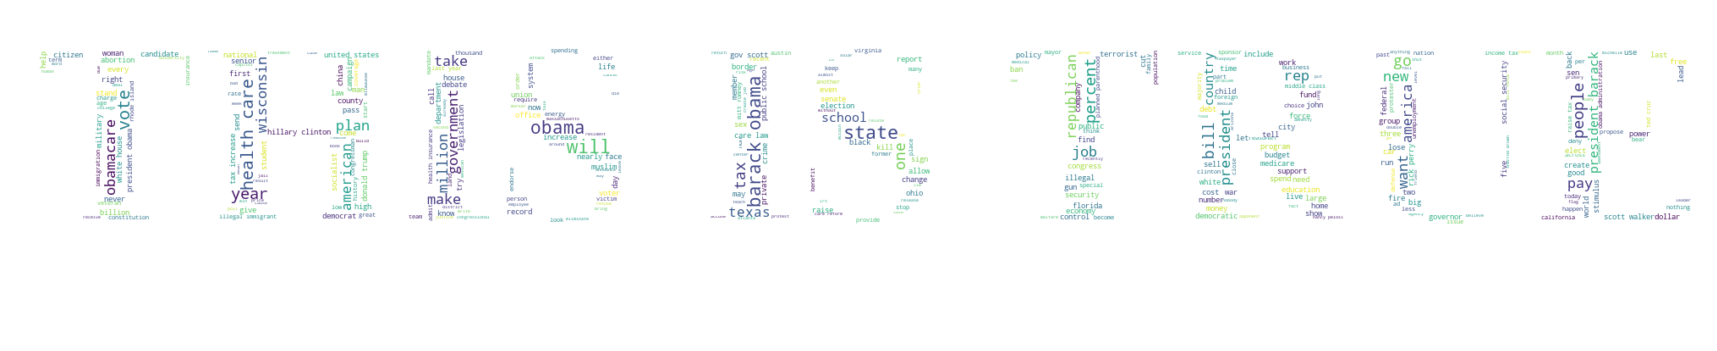

In [87]:
simple_wordcloud(get_proper_lemmas(1),'res/portraits/TIT.png')

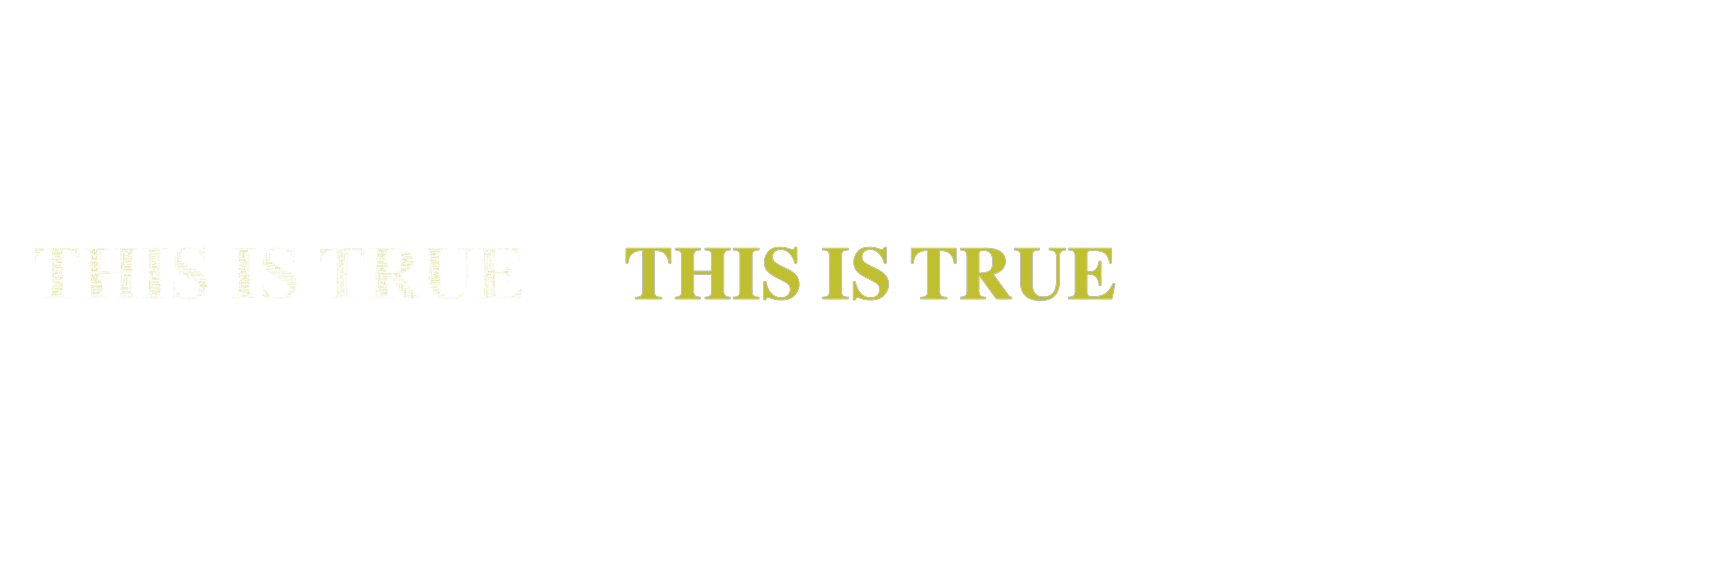

In [88]:
wordcloud(get_proper_lemmas(1),'res/portraits/TIT.png')

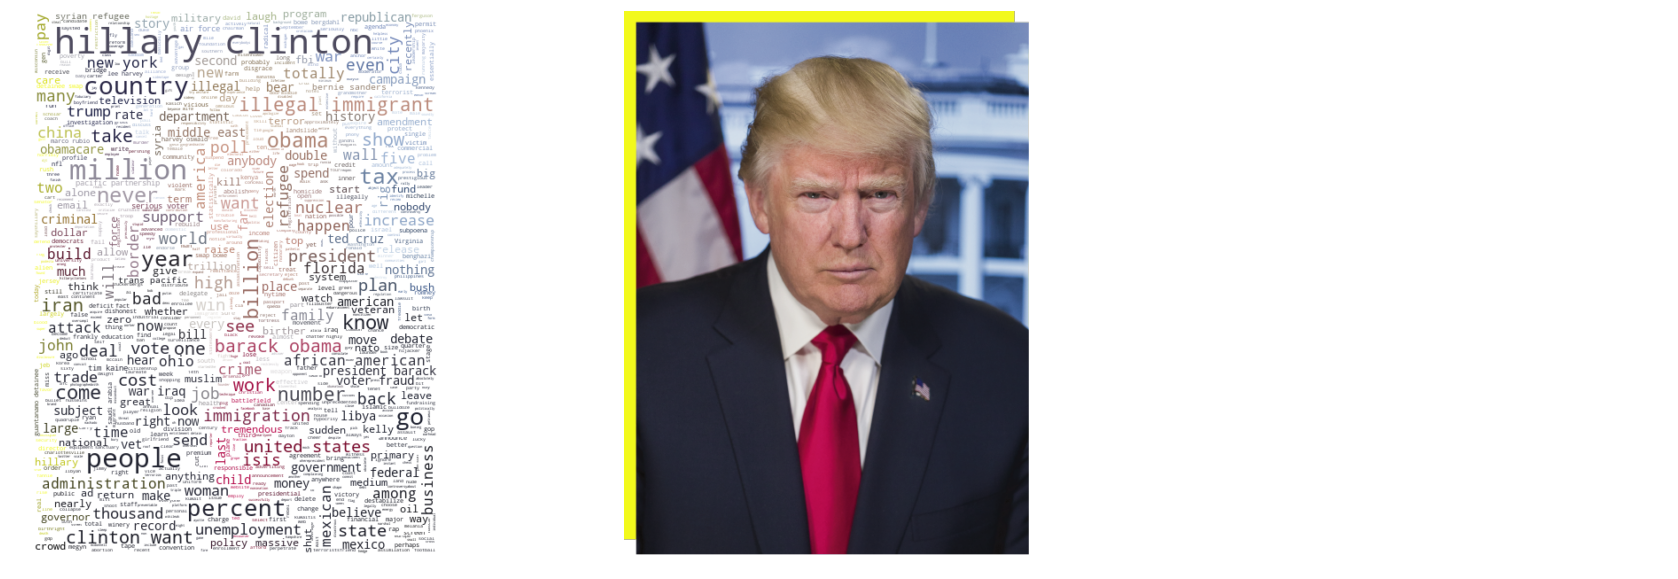

In [89]:
wordcloud(get_proper_lemmas(3),'res/portraits/TRUY.png')

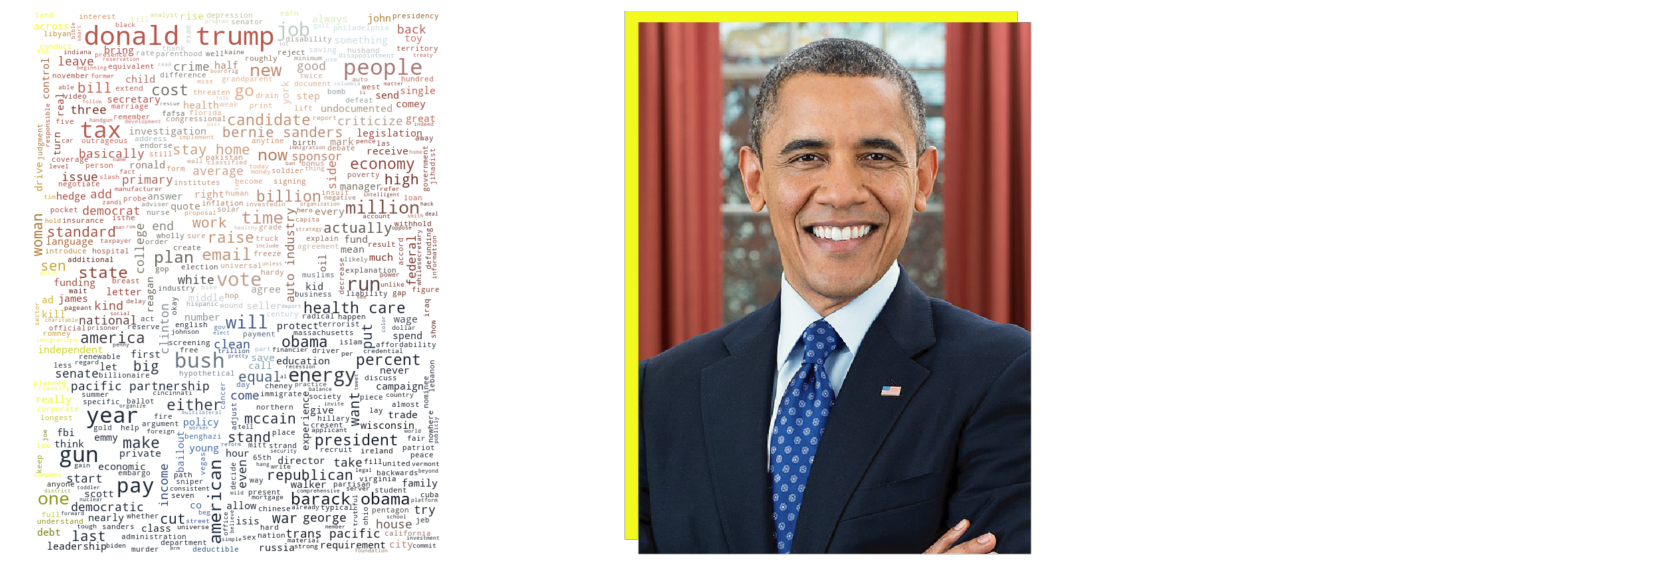

In [90]:
wordcloud(get_proper_lemmas(4),'res/portraits/OBAY.png')

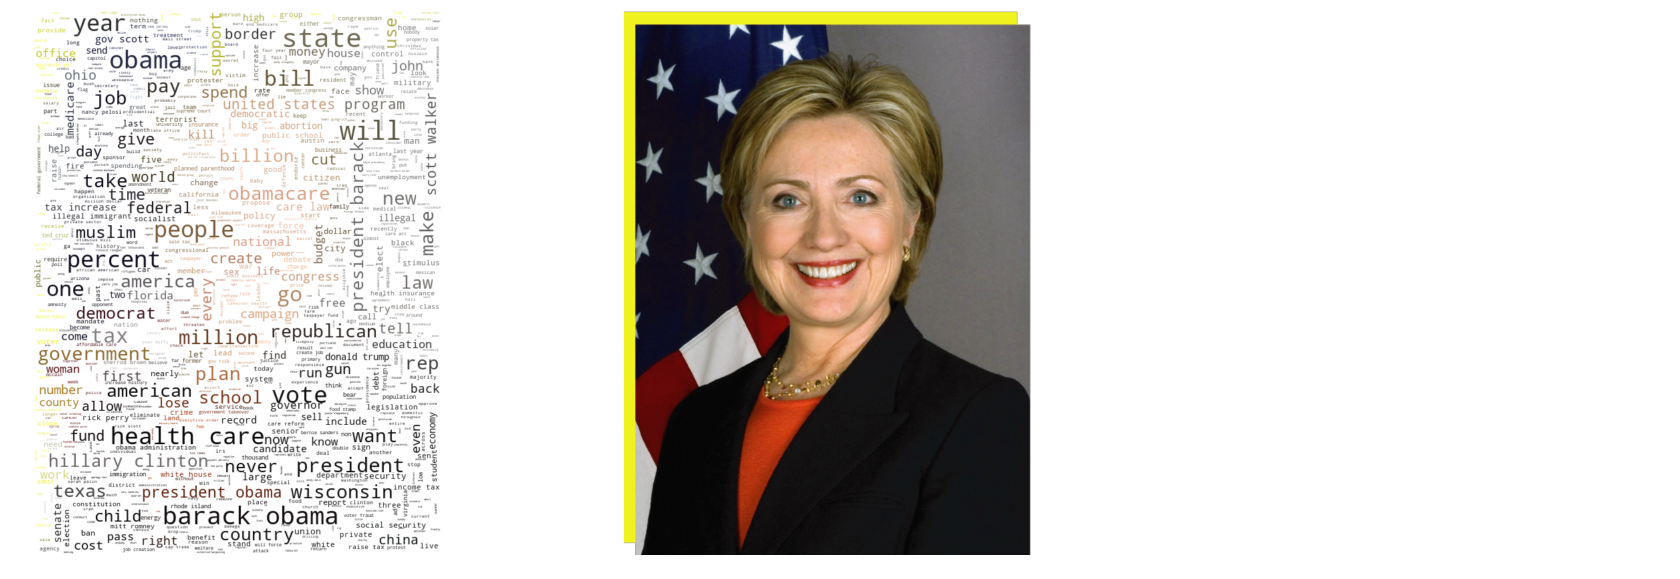

In [91]:
wordcloud(get_proper_lemmas(1),'res/portraits/CLIY.png')

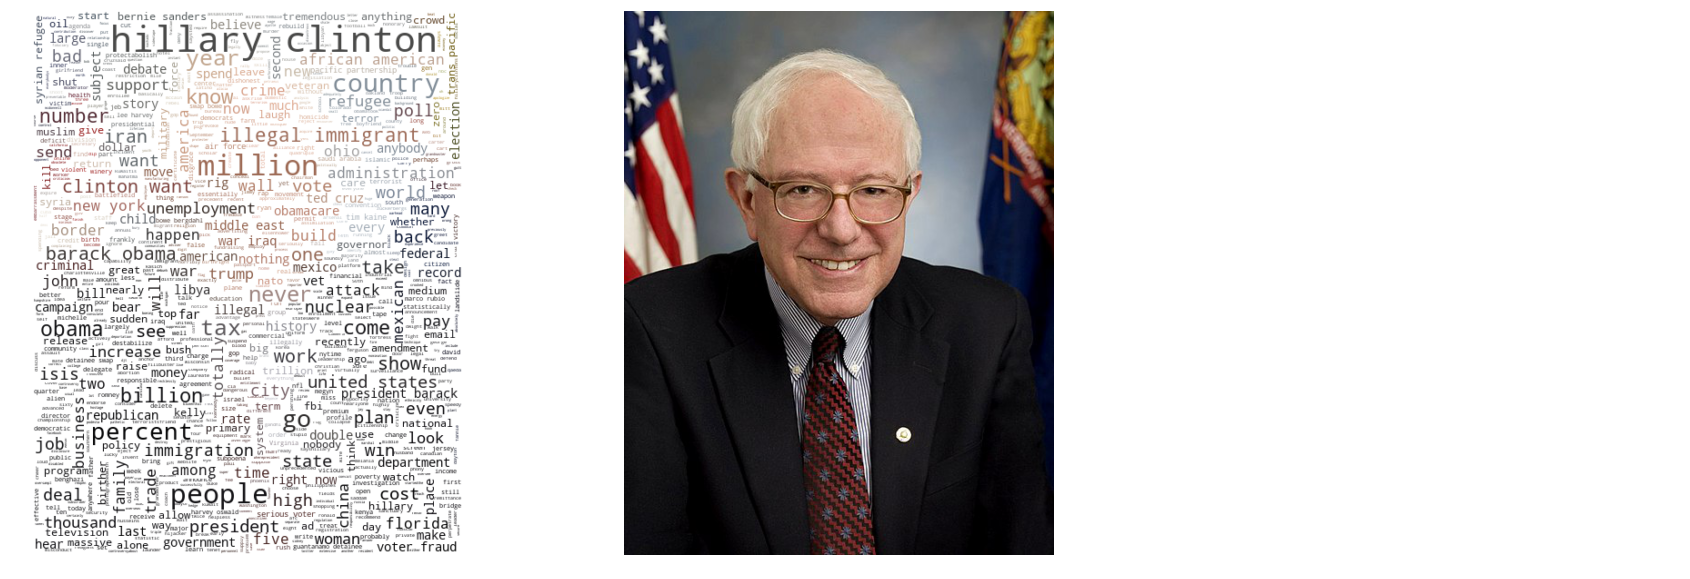

In [92]:
wordcloud(get_proper_lemmas(3),'res/portraits/Sanders.jpg')

In [93]:
# Function to get the most used words per speaker.
def get_common_words(lemmas,number_of_words):
    doc = nlp(lemmas)
    words = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ != 'DET']
    word_freq = Counter(words)
    common_words = word_freq.most_common(number_of_words)
    return common_words

In [95]:
# Get the n_wanted first most used words by speaker ... 
n_wanted = 15
common_words_obama = get_common_words(get_proper_lemmas(2),n_wanted)
common_words_trump = get_common_words(get_proper_lemmas(3),n_wanted)
common_words_clinton = get_common_words(get_proper_lemmas(4),n_wanted)

In [96]:
#... and print them
print('Obama :',common_words_obama)
print('Trump :',common_words_trump)
print('Clinton :',common_words_clinton)

Obama : [(' ', 151), ('health', 34), ('care', 31), ('$', 29), ('year', 27), ('plan', 25), ('percent', 23), ('tax', 22), ('job', 22), ('million', 22), ('s', 21), ('obama', 19), ('romney', 19), ('mitt', 17), ('insurance', 16)]
Trump : [(' ', 143), ('clinton', 43), ('hillary', 42), ('million', 23), ('people', 20), ('$', 19), ('obama', 17), ('country', 17), ('want', 16), ('percent', 15), ('illegal', 14), ('tax', 14), ('year', 13), ('president', 12), ('know', 11)]
Clinton : [(' ', 56), ('donald', 15), ('trump', 13), ('tax', 11), ('$', 10), ('year', 10), ('obama', 10), ('people', 10), ('gun', 10), ('pay', 9), ('job', 8), ('bush', 8), ('s', 8), ('energy', 8), ('vote', 8)]


### Positivity/Negativity analysis

In this part, the goal is to get a notion of the positivity, negativity or neutrality of the false informations that a given speaker spread. Using the vader sentiment analysis tool, it was possible to do so.

In [97]:
#Load the sentiment analyzer.
analyzer = SentimentIntensityAnalyzer()

In [98]:
#get the number of sentences of a given sentiment, plot the distribution and save it into an array.
def sentiment_analyser(speaker_number,speaker_name):
    doc = nlp(speakers[speaker_number])
    total_sent = []
    [total_sent.append(analyzer.polarity_scores(sent.text)['compound']) for sent in doc.sents]
    plt.hist(total_sent,bins = 15)
    plt.title(speaker_name)
    plt.xlabel('Compound sentiment')
    plt.ylabel('Number of sentences')
    plt.show()

    sents = [analyzer.polarity_scores(sent.text)['compound'] for sent in doc.sents]
    print('Percentage of positive sentences:',sum(np.array(sents)>=0.05)/len(sents)*100)
    print('Percentage of negative sentences:',sum(np.array(sents)<=-0.05)/len(sents)*100)
    print('Percentage of neutral sentences:',sum(np.abs(np.array(sents))<0.05)/len(sents)*100)

    pos = sum(np.array(sents)>=0.05)/len(sents)*100
    neg = sum(np.array(sents)<=-0.05)/len(sents)*100
    neu = sum(np.abs(np.array(sents))<0.05)/len(sents)*100
    speaker_sentiments = ([round(neg,2),round(neu,2),round(pos,2)])
    return speaker_sentiments

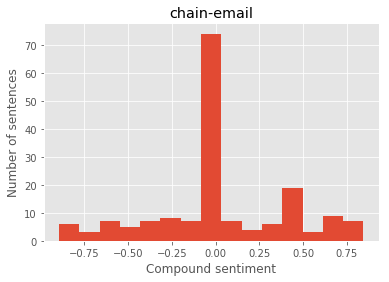

Percentage of positive sentences: 31.976744186046513
Percentage of negative sentences: 27.325581395348834
Percentage of neutral sentences: 40.69767441860465


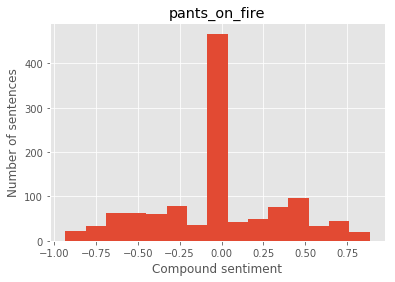

Percentage of positive sentences: 30.548523206751057
Percentage of negative sentences: 30.970464135021096
Percentage of neutral sentences: 38.48101265822785


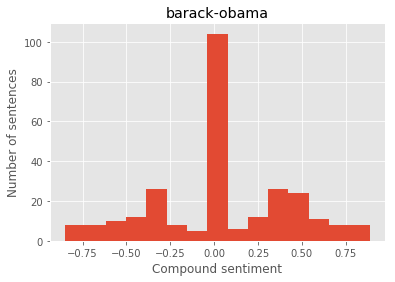

Percentage of positive sentences: 34.78260869565217
Percentage of negative sentences: 27.898550724637683
Percentage of neutral sentences: 37.31884057971014


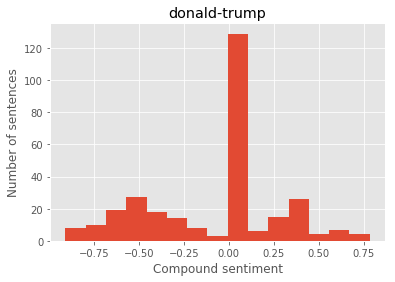

Percentage of positive sentences: 21.812080536912752
Percentage of negative sentences: 35.23489932885906
Percentage of neutral sentences: 42.95302013422819


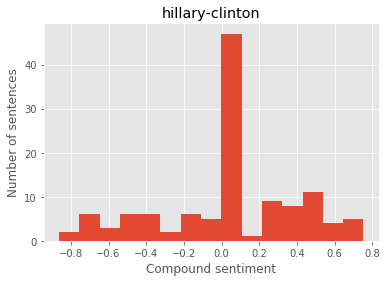

Percentage of positive sentences: 33.057851239669425
Percentage of negative sentences: 28.92561983471074
Percentage of neutral sentences: 38.01652892561984


In [99]:
#Get the sentiment of each speaker and display the distribution
email_sentiments = sentiment_analyser(0,'chain-email')
POF_sentiments = sentiment_analyser(1,'pants_on_fire')
obama_sentiments = sentiment_analyser(2,'barack-obama')
trump_sentiments = sentiment_analyser(3,'donald-trump')
clinton_sentiments = sentiment_analyser(4,'hillary-clinton')

In [100]:
#Print the sentiments for each speaker
print('Email :',email_sentiments)
print('POF :',POF_sentiments)
print('Obama :',obama_sentiments)
print('Trump :',trump_sentiments)
print('Clinton :',clinton_sentiments)

Email : [27.33, 40.7, 31.98]
POF : [30.97, 38.48, 30.55]
Obama : [27.9, 37.32, 34.78]
Trump : [35.23, 42.95, 21.81]
Clinton : [28.93, 38.02, 33.06]


#Radar chart of the speakers sentiments
data = [
    go.Scatterpolar(
      r = obama_sentiments,
      theta = ['Neg','Neu','Pos'],
      fill = 'toself',
      name = 'Obama'
    ),
    go.Scatterpolar(
      r = trump_sentiments,
      theta = ['Neg','Neu','Pos'],
      fill = 'toself',
      name = 'Trump'
    )
]
layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
    )
  ),
  showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = "SENTIMENT")

----
----

## <font color=#303030>Our project: what is next?</font> 

### <font color=#856514>  The action plan </font> 

<div class="alert alert-block alert-info"><b>Our plan for the next weeks :</b><br />
<br />
- <b>Objective 1</b>: Expand our preliminary analysis to more detailed answering of the main questions, with careful preprocessing of the data. <br />	
- <b>Objective 2</b>: Find another relevant news dataset and check if our insights can be generalized to different sources. <br />
- <b>Objective 3</b>: Make an interactive visualization to engage the user, selecting between a graph or flow chart.<br />
</div>

### <font color=#856514> The report plan  </font> 

* As we have already pointed out on several occasions, our database is subject to many biases that makes it difficult to generalize our results. Despite the goodwill of Politifact journalists and contributors, the sample presented in these data is certainly not representative of fakes news activity in the United States. While it is useful for classifying new data, it is not useful for drawing conclusions. What we want to do with this work is above all to exercise the skills we learned during the course and extract information from the data available. As we have seen, the relevance of this information must be confirmed through our critical thinking. We would therefore like to find a second dataset and check if our insights can be generalized to statements of different countries, periods and sources, hopefully in an international level. In particular we will to answer the same questions and compare as well as explain the differences in the results.
* Moreover, we will improve our existing analysis and respective plots by processing the numerous text fields with the most generic - possibly NLP assisted - methods, aiming to avoid hard-coded solutions.
* Besides our already implemented visualizations, we would to experiment with more intricate and **interactive** alternatives. In particular we believe a graph would be a good choice as it allows for both a high level overview of the dataset, as well as (for example with selection or zooming) a more fine-grained view between a pair of specific nodes. We will evaluate the possible semantics of nodes, edges and design a functioning prototype using frameworks like D3.js. Another option we are considering is a Streamgraph. This particular type of visualization is ideal for discovering patterns over time and would be ideal to present the rise of fake news before important events like elections.

We propose this data story plan :
* **A) Introduction :**
    Where we introduce our goals and present our data
* **B) The fake news menace :**
    In this section, we will study the rise of the fake news over time and some interesting distribution properties.
* **C) The fake war :**
    In this section, we will study the relationship between liars and the subject they like to lie about
* **D) The revenge of the liar :**
    In this section, we will study famous politician and understand where they lie and about what they lie. 

## The data story can be found in the following [link](https://nicolasfontbonne.github.io)